# Import libraries

In [105]:
!pip install cfgrib
!pip install xarray
!pip install eccodes
!pip install rasterio
!pip install scipy

In [106]:
import os
import glob
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [107]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
plt.style.use("seaborn-v0_8")

In [108]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/SafeTravelPH Data")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Climatic Analysis

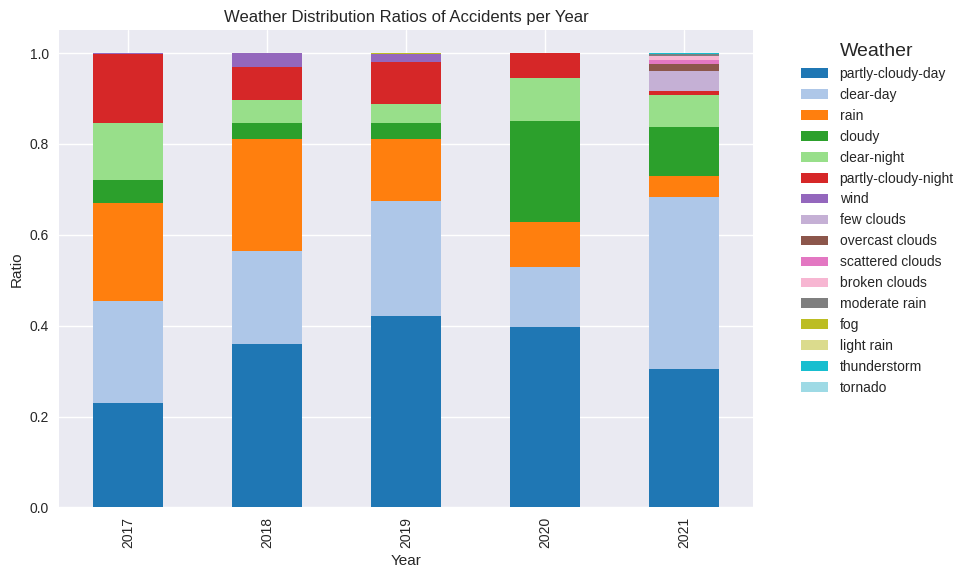

In [109]:
df1 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2017.csv")
df2 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2018.csv")
df3 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2019.csv")
df4 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2020.csv")
df5 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2021.csv")

dfs = {
    '2017': df1,
    '2018': df2,
    '2019': df3,
    '2020': df4,
    '2021': df5,
}

weather_ratios = {}

for year, df in dfs.items():
    df.columns = df.columns.str.strip()
    df['weather'] = df['weather'].str.strip().str.lower()

    counts = df['weather'].value_counts(normalize=True).sort_index()
    weather_ratios[year] = counts

weather_df = pd.DataFrame(weather_ratios).T.fillna(0)
weather_df = weather_df[weather_df.mean().sort_values(ascending=False).index]
weather_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.title('Weather Distribution Ratios of Accidents per Year')
plt.ylabel('Ratio')
plt.xlabel('Year')
plt.legend(title='Weather', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Spatial Analysis

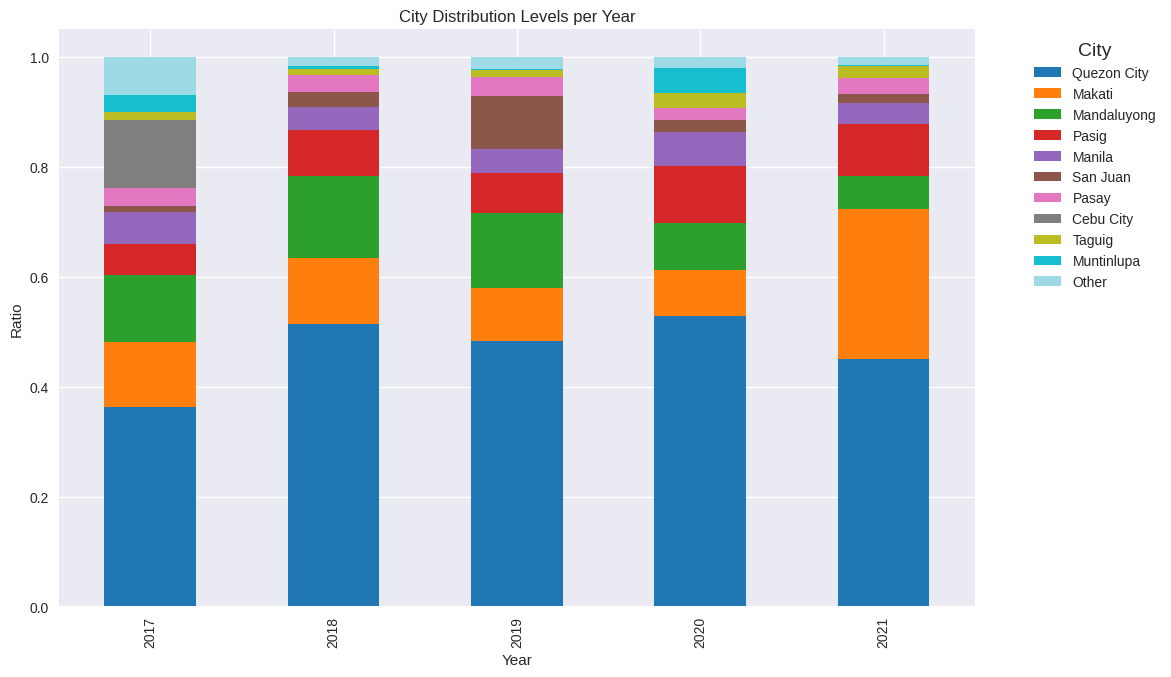

In [110]:


city_map = {
    'quezon city': 'Quezon City',
    'muntinlupa': 'Muntinlupa',
    'pasig': 'Pasig',
    'zambales': 'Zambales',
    'misamis oriental': 'Misamis Oriental',
    'mandaluyong': 'Mandaluyong',
    'cubao': 'Cubao',
    'makati': 'Makati',
    'pasay': 'Pasay',
    'taguig': 'Taguig',
    'san juan': 'San Juan',
    'calapan': 'Calapan',
    'oriental mindoro': 'Oriental Mindoro',
    'rizal': 'Rizal',
    'parañaque': 'Parañaque',
    'lanao del norte': 'Lanao Del Norte',
    'lanao del sur': 'Lanao del Sur',
    'cebu': 'Cebu City',
    'manila': 'Manila',
    'cotabato city': 'Cotabato City',
    'alabang': 'Muntinlupa',
    'iligan city': 'Iligan City',
    'zamboanga del norte': 'Zamboanga del Norte',
    'surigao': 'Surigao',
    'butuan': 'Butuan',
    'agusan del norte': 'Agusan del Norte',
    'agusan del sur': 'Agusan del Sur',
    'bohol': 'Bohol',
    'lagro': 'Quezon City',
    'bacolod': 'Lanao Del Norte',
    'dinagat islands': 'Dinagat Islands',
    'guimaras': 'Guimaras',
    'ilocos norte': 'Ilocos Norte',
}

def extract_city(location_text):
    if pd.isna(location_text):
        return None
    location_text_lower = str(location_text).lower()
    for key, city in city_map.items():
        if key in location_text_lower:
            return city
    return None

dfs = {
    '2017': df1,
    '2018': df2,
    '2019': df3,
    '2020': df4,
    '2021': df5,
}

location_ratios = {}

for year, df in dfs.items():
    df.columns = df.columns.str.strip()

    df['city'] = df['location_text'].apply(extract_city)

    df = df.dropna(subset=['location_text', 'city'])

    ratios = df['city'].value_counts(normalize=True)

    location_ratios[year] = ratios

location_df = pd.DataFrame(location_ratios).fillna(0)

location_df['total'] = location_df.sum(axis=1)
location_df = location_df.sort_values('total', ascending=False).drop(columns='total')

top_n = 10
if len(location_df) > top_n:
    top_locations = location_df.head(top_n)
    others = location_df.iloc[top_n:].sum().to_frame(name='Other').T
    location_df = pd.concat([top_locations, others])

location_df.T.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    colormap='tab20'
)

plt.title('City Distribution Levels per Year')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Demographic Analysis

In [111]:
df1 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2017.xlsx - person.csv")
df2 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2018.xlsx - person.csv")
df3 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2019.xlsx - person.csv")
df4 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2020.xlsx - person.csv")
df5 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2021.xlsx - person.csv")


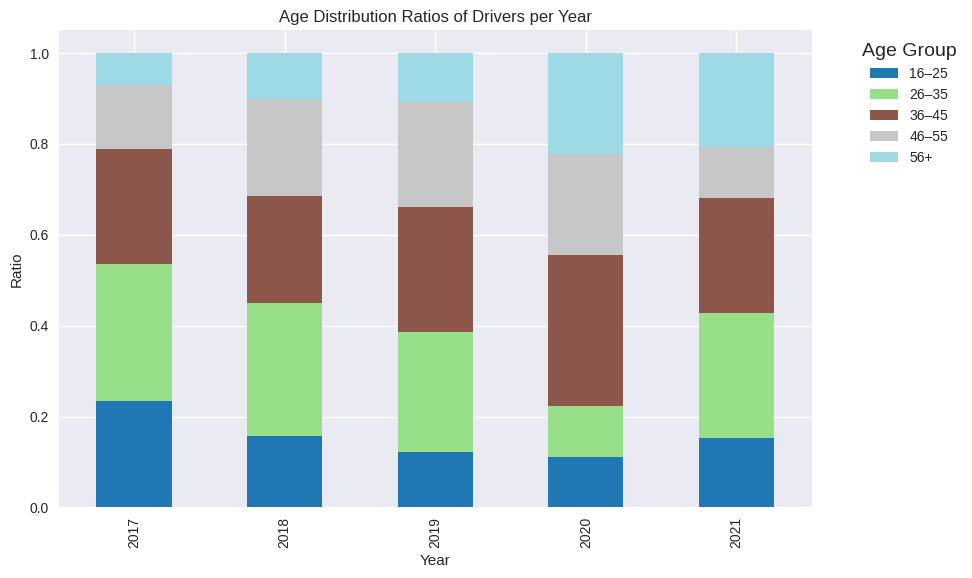

In [112]:
for df in [df1, df2, df3, df4, df5]:
    df.columns = df.columns.str.strip()

dfs = {
    '2017': df1,
    '2018': df2,
    '2019': df3,
    '2020': df4,
    '2021': df5,
}

bins = [16, 25, 35, 45, 55, float('inf')]
labels = ['16–25', '26–35', '36–45', '46–55', '56+']

age_dist_ratios = {}

for year, df in dfs.items():
    df.columns = df.columns.str.strip()
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

    drivers = df[(df['Involvment'] == 'Driver') & (df['Age'] >= 0)]
    binned = pd.cut(drivers['Age'], bins=bins, labels=labels, right=True)
    counts = binned.value_counts(normalize=True).sort_index()

    age_dist_ratios[year] = counts

age_ratio_df = pd.DataFrame(age_dist_ratios).T
age_ratio_df.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')

plt.title('Age Distribution Ratios of Drivers per Year')
plt.ylabel('Ratio')
plt.xlabel('Year')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


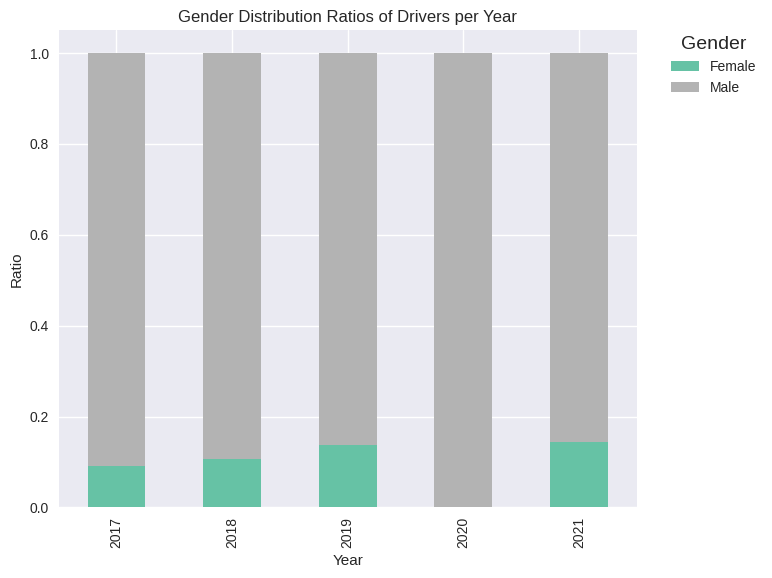

In [113]:
dfs = {
    '2017': df1,
    '2018': df2,
    '2019': df3,
    '2020': df4,
    '2021': df5,
}

gender_ratios = {}

for year, df in dfs.items():
    df.columns = df.columns.str.strip()
    df['Gender'] = df['Gender'].str.strip().str.capitalize()

    drivers = df[(df['Involvment'] == 'Driver') & (df['Gender'].isin(['Male', 'Female']))]

    counts = drivers['Gender'].value_counts(normalize=True).sort_index()
    gender_ratios[year] = counts

gender_df = pd.DataFrame(gender_ratios).T.fillna(0)
gender_df = gender_df[['Female', 'Male']]

gender_df.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Set2')

plt.title('Gender Distribution Ratios of Drivers per Year')
plt.ylabel('Ratio')
plt.xlabel('Year')
plt.legend(
    title='Gender',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)
plt.tight_layout()
plt.show()


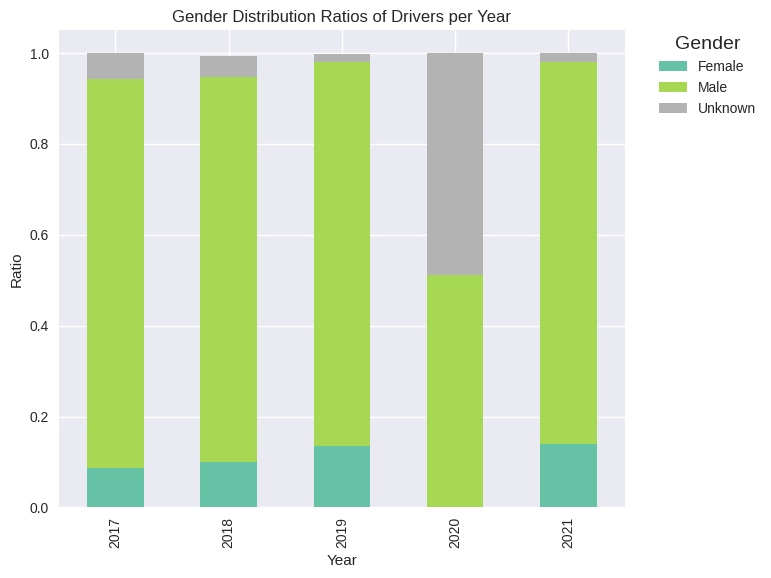

In [114]:
dfs = {
    '2017': df1,
    '2018': df2,
    '2019': df3,
    '2020': df4,
    '2021': df5,
}

gender_ratios = {}

for year, df in dfs.items():
    df.columns = df.columns.str.strip()

    df['Gender'] = df['Gender'].str.strip().str.capitalize()
    df['Gender'] = df['Gender'].fillna('Unknown')
    drivers = df[df['Involvment'] == 'Driver']

    counts = drivers['Gender'].value_counts(normalize=True).reindex(['Female', 'Male', 'Unknown'], fill_value=0)

    gender_ratios[year] = counts

gender_df = pd.DataFrame(gender_ratios).T
gender_df = gender_df[['Female', 'Male', 'Unknown']]
gender_df.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Set2')

plt.title('Gender Distribution Ratios of Drivers per Year')
plt.ylabel('Ratio')
plt.xlabel('Year')
plt.legend(
    title='Gender',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)
plt.tight_layout()
plt.show()


# Vehicle  Analysis

In [115]:
df1 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2017.xlsx - vehicle.csv")
df2 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2018.xlsx - vehicle.csv")
df3 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2019.xlsx - vehicle.csv")
df4 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2020.xlsx - vehicle.csv")
df5 = pd.read_csv("/content/drive/My Drive/SafeTravelPH Data/2021.xlsx - vehicle.csv")

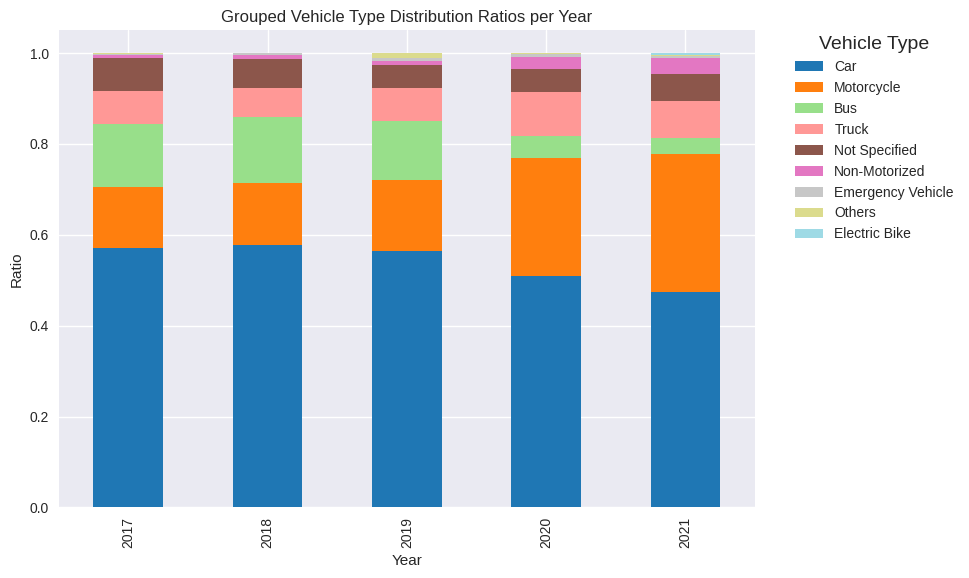

In [116]:
dfs = {
    '2017': df1,
    '2018': df2,
    '2019': df3,
    '2020': df4,
    '2021': df5,
}

vehicle_map = {
    'Car': 'Car',
    'Suv': 'Car',
    'SUV': 'Car',
    'Taxi (Metered)': 'Car',
    'Van': 'Car',

    'Electric Bike': 'Electric Bike',
    'Motorcycle': 'Motorcycle',
    'Tricycle': 'Motorcycle',

    'Bus': 'Bus',
    'Jeepney': 'Bus',

    'Truck (Pick-Up)': 'Truck',
    'Truck (Unknown)': 'Truck',
    'Truck (Articulated)': 'Truck',
    'Truck (Rigid)': 'Truck',
    'Truck (Fire)': 'Truck',

    'Ambulance': 'Emergency Vehicle',
    'Armored Car': 'Emergency Vehicle',

    'Bicycle': 'Non-Motorized',
    'Pedestrian': 'Non-Motorized',
    'Push-Cart': 'Non-Motorized',
    'Pedicab': 'Non-Motorized',

    'Heavy Equipment': 'Others',
    'Others': 'Others'
}

vehicle_ratios = {}

for year, df in dfs.items():
    df.columns = df.columns.str.strip()

    df['Vehicle Type'] = df['Vehicle type'].astype(str).str.strip().str.title()
    df['Vehicle Group'] = df['Vehicle type'].map(vehicle_map).fillna('Not Specified')

    counts = df['Vehicle Group'].value_counts(normalize=True)
    vehicle_ratios[year] = counts

vehicle_df = pd.DataFrame(vehicle_ratios).T.fillna(0)
vehicle_df = vehicle_df[vehicle_df.sum().sort_values(ascending=False).index]

vehicle_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.title('Grouped Vehicle Type Distribution Ratios per Year')
plt.ylabel('Ratio')
plt.xlabel('Year')
plt.legend(
    title='Vehicle Type',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)
plt.tight_layout()
plt.show()


In [117]:
dfs = {
    '2017': df1,
    '2018': df2,
    '2019': df3,
    '2020': df4,
    '2021': df5,
}

classification_ratios = {}

for year, df in dfs.items():
    df.columns = df.columns.str.strip()

    df['Classification'] = df['Classification'].astype(str).str.strip().str.title()
    df['Classification'] = df['Classification'].replace(['Nan', '', 'None'], 'Not Specified')

    year_ratios = df['Classification'].value_counts(normalize=True) * 100
    classification_ratios[year] = year_ratios

ratios_df = pd.DataFrame(classification_ratios).T.fillna(0)
ratios_df.loc['Average'] = ratios_df.mean()

ratios_df = ratios_df[ratios_df.loc['Average'].sort_values(ascending=False).index]

print("\nPercentage Ratio of Vehicle Classifications per Year and On Average:\n")
print(ratios_df.round(2))


Percentage Ratio of Vehicle Classifications per Year and On Average:

Classification  Private  Not Specified  Public / For-Hire  Government  \
2017              78.62           0.61              20.21        0.44   
2018              32.28          59.10               8.48        0.12   
2019              36.29          55.59               7.98        0.10   
2020              67.73          24.90               6.94        0.43   
2021              74.16          16.03               8.79        0.97   
Average           57.82          31.24              10.48        0.41   

Classification  Diplomat  
2017                0.13  
2018                0.01  
2019                0.04  
2020                0.00  
2021                0.05  
Average             0.05  


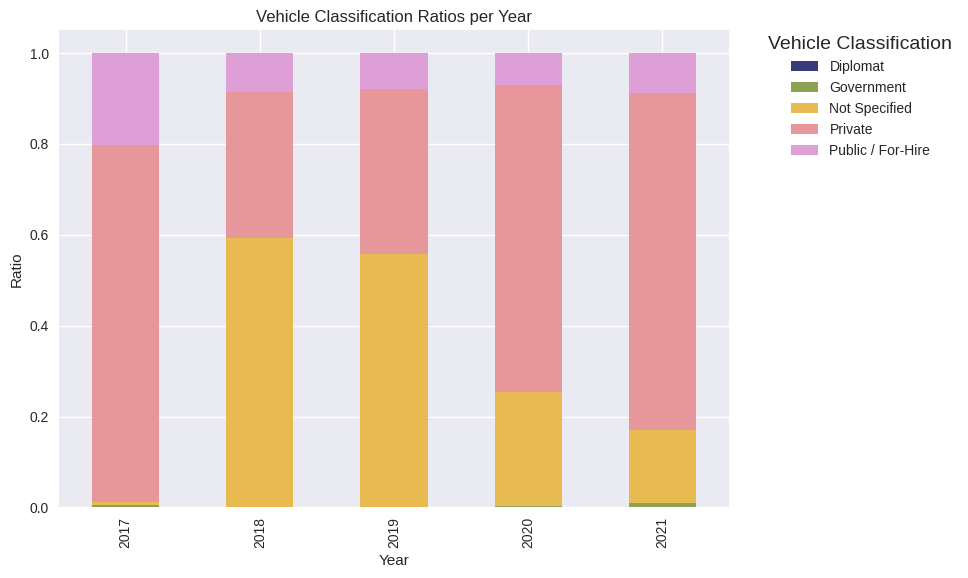

In [118]:
dfs = {
    '2017': df1,
    '2018': df2,
    '2019': df3,
    '2020': df4,
    '2021': df5,
}

vehicle_ratios = {}

for year, df in dfs.items():
    df = df.copy()
    counts = df['Classification'].value_counts(normalize=True)

    vehicle_ratios[year] = counts

# Create DataFrame and reindex to include all vehicle types consistently
vehicle_df = pd.DataFrame(vehicle_ratios).T.fillna(0)

vehicle_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20b')

plt.title('Vehicle Classification Ratios per Year')
plt.ylabel('Ratio')
plt.xlabel('Year')
plt.legend(
    title='Vehicle Classification',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)
plt.tight_layout()
plt.show()